# Introduction to Stable Diffusion 

## Generate image from text

In [ ]:
# install diffusers
%pip install -U diffusers

In [2]:
import torch
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , torch_dtype = torch.float16
).to("cuda:0")

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
safety_checker\model.safetensors not found
d:\az_git_folder\azcode\azcode_venv_win_p310\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

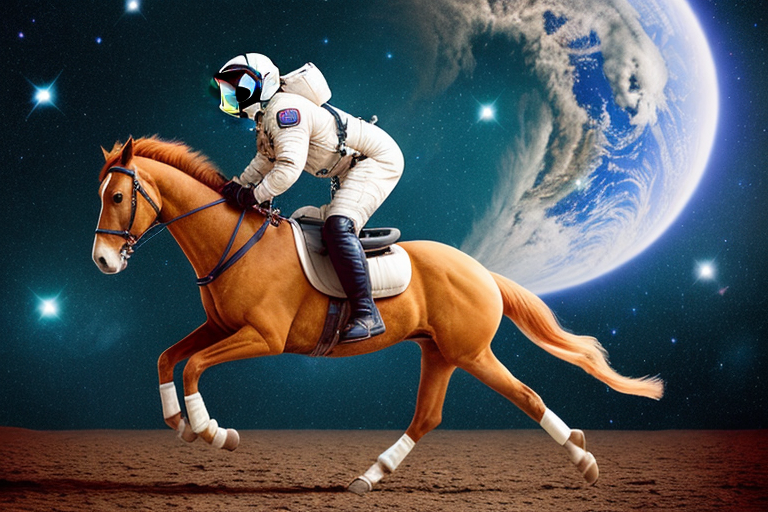

In [3]:
prompt = "a photograph of an astronaut riding a horse"
image = pipe(
    prompt          = prompt
    , generator     = torch.Generator("cuda:0").manual_seed(6)
    , width         = 768
    , height        = 512
).images[0]
display(image)

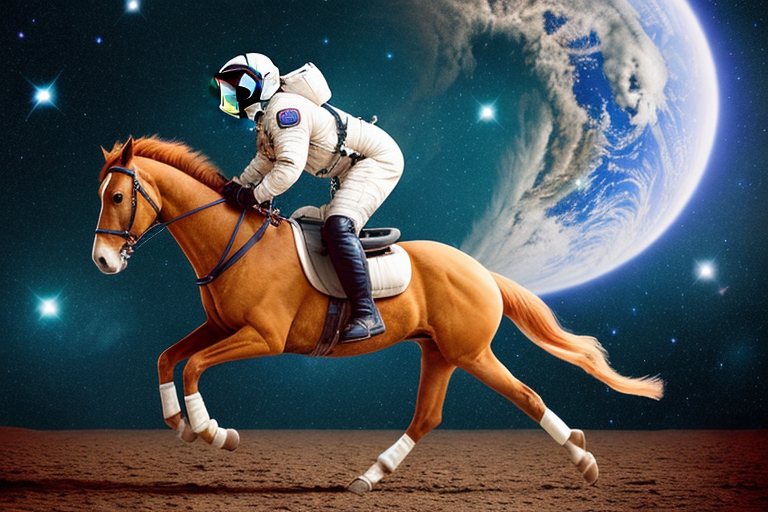

In [161]:
image

## Detect the backgroud

In [4]:
from transformers import CLIPSegProcessor,CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
)
model = CLIPSegForImageSegmentation.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
)

torch.Size([352, 352])


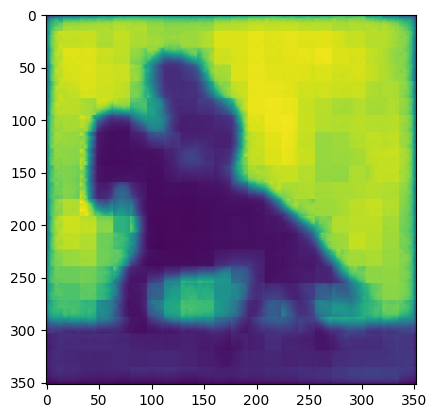

In [7]:
# generate mask data
import matplotlib.pyplot as plt
prompts = ['the background']
inputs = processor(
    text             = prompts
    , images         = [image] * len(prompts)
    , padding        = True
    , return_tensors = "pt"
)

with torch.no_grad():
    outputs = model(**inputs)

preds = outputs.logits

mask_data = torch.sigmoid(preds)
print(mask_data.shape)
plt.imshow(mask_data)

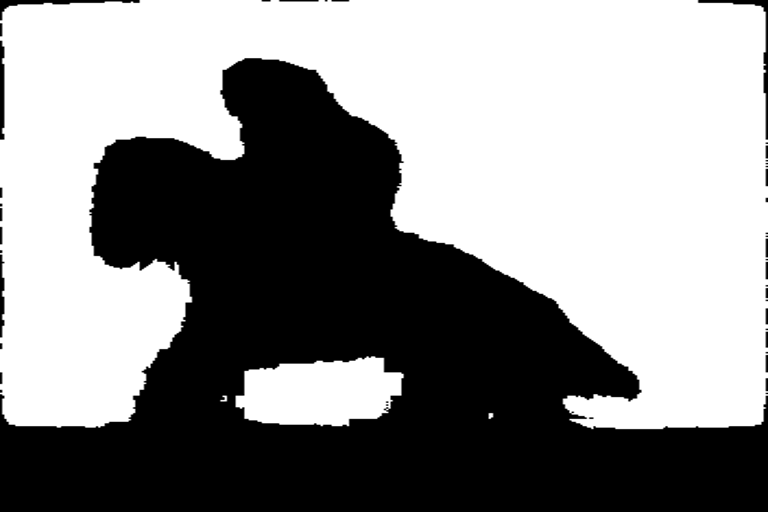

In [8]:
# genearte mask binary image
import cv2
from PIL import Image
mask_file_name = f"bg_mask.png"
plt.imsave(mask_file_name,mask_data) 
mask_data_cv = cv2.imread(mask_file_name) # -> (352, 352, 3)

def get_mask_img(mask_data):
    gray_image = cv2.cvtColor(mask_data,cv2.COLOR_BGR2GRAY)
    thresh, bw_image = cv2.threshold(gray_image,100,255,cv2.THRESH_BINARY)
    cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)
    return Image.fromarray(bw_image)

bw_image = get_mask_img(mask_data=mask_data_cv)
#cv2.imwrite(bw_image)
bw_image = bw_image.resize((768,512))
bw_image

In [155]:
# Start a inpaint pipeline
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4"
    , torch_dtype = torch.float16
    , safety_checker = None
).to("cuda:0")
#inpaint_pipe.scheduler = EulerDiscreteScheduler.from_config(inpaint_pipe.scheduler.config)

text_encoder\model.safetensors not found
d:\az_git_folder\azcode\azcode_venv_win_p310\lib\site-packages\diffusers\pipelines\pipeline_utils.py:944: FutureWarning: You are using a legacy checkpoint for inpainting with Stable Diffusion, therefore we are loading the <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> class instead of <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'>. For better inpainting results, we strongly suggest using Stable Diffusion's official inpainting checkpoint: https://huggingface.co/runwayml/stable-diffusion-inpainting instead or adapting your checkpoint CompVis/stable-diffusion-v1-4 to the format of https://huggingface.co/runwayml/stable-diffusion-inpainting. Note that we do not actively maintain the {StableDiffusionInpaintPipelineLegacy} class and will likely remove it in version 1.0.0.
  deprecate("StableDiffusionInpaintPipe

  0%|          | 0/45 [00:00<?, ?it/s]

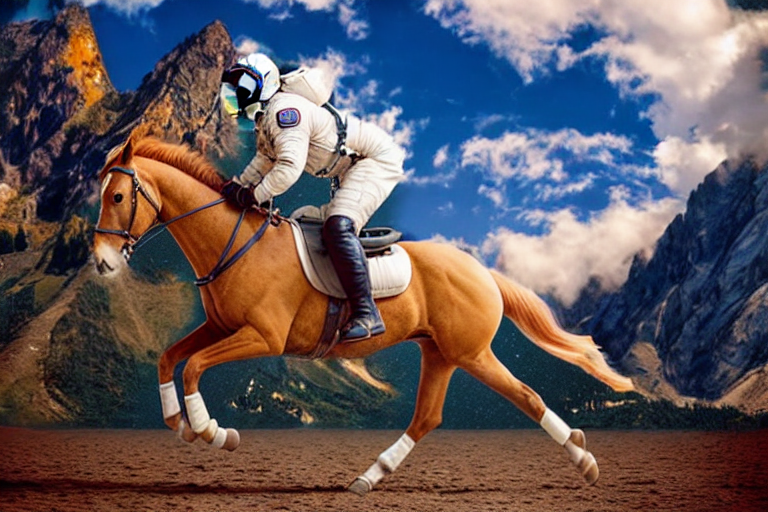

In [220]:
# change the background
sd_prompt = "blue sky and mountains"
out_image = inpaint_pipe(
    prompt          = sd_prompt
    , image         = image
    , mask_image    = bw_image
    , strength      = 0.9
    , generator     = torch.Generator("cuda:0").manual_seed(7)
    # , guidance_scale = 7.5
    # , num_inference_steps = 50
    # , width = 768
    # , height = 512
).images[0]
out_image